# Minimum Entropy Loss
https://discuss.pytorch.org/t/calculating-the-entropy-loss/14510

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
π = np.pi
from numpy.random import uniform as uni
from tqdm import tqdm

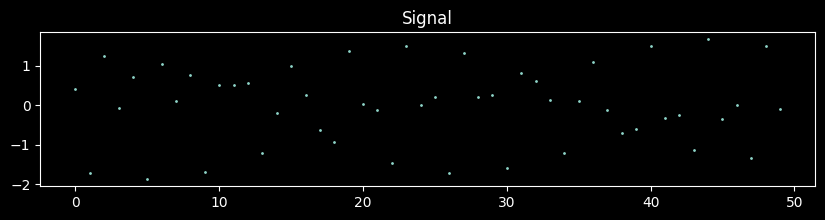

In [51]:
# generate a random signal as a sum of random frequencies
N_FREQS = 5
N_SAMPLES = 50

# generate random frequencies
fs = uni(0, N_SAMPLES/20, N_FREQS)
As = uni(0, 1, N_FREQS)
φs = uni(0, 2*π, N_FREQS)
t = np.arange(N_SAMPLES)

# generate the signal
x = np.sum([As[i]*np.sin(2*π*fs[i]*t+φs[i]) for i in range(N_FREQS)], axis=0)
# x = uni(-uni(.2, 1.2), +uni(.2, 1.2), N_SAMPLES)

#plot the signal
plt.figure(figsize=(10, 2))
plt.scatter(t,x, s=1)
plt.title('Signal')
plt.show()

levels: [-2.1  -1.95 -1.8  -1.65 -1.5  -1.35 -1.2  -1.05 -0.9  -0.75 -0.6  -0.45
 -0.3  -0.15  0.    0.15  0.3   0.45  0.6   0.75  0.9   1.05  1.2   1.35
  1.5   1.65  1.8   1.95  2.1 ]
number of levels: 27
levels: [-1.8 -1.5 -1.2 -0.9 -0.6 -0.3 -0.   0.3  0.6  0.9  1.2  1.5  1.8]
number of levels: 13


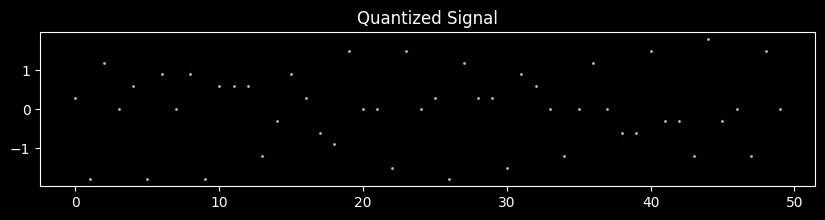

In [52]:
# quantize the signal
EPSI = 0.15

nlevels = 1+np.ceil(np.max(np.abs(x))/EPSI)
levels = EPSI*np.arange(-nlevels, nlevels+1)
nlevels = int(1+2*np.ceil(np.max(np.abs(x))/EPSI))
print(f'levels: {levels}')
print(f'number of levels: {nlevels}')

# def quantize(x, ε): return ε*np.round(x/ε) 
def quantize(x, ε): return 2*ε*np.round(x/(2*ε)) 

xq = quantize(x, EPSI)

print(f'levels: {np.unique(xq)}')
print(f'number of levels: {np.unique(xq).shape[0]}')

# plot the quantized signal
plt.figure(figsize=(10, 2))
# plt.plot(t,x, label='original')
plt.scatter(t,xq, label='quantized', s=1)
plt.title('Quantized Signal')
plt.show()

In [53]:
# measure entropy of the signal
def entropy(x):
    _, counts = np.unique(x, return_counts=True)
    p = counts/len(x)
    # return -np.sum(p*np.log2(p))
    return -np.sum(p*np.log(p))

print(f'Entropy of the quantized signal: {entropy(xq):.2f}')

Entropy of the quantized signal: 2.42


In [54]:
class HLoss(nn.Module):
    def __init__(self):
        super(HLoss, self).__init__()

    def forward(self, x):
        assert x.size(-1) == nlevels, f'x.size: {x.size()}'
        b = F.softmax(x, dim=-1) * F.log_softmax(x, dim=-1)
        b = -1.0 * b.sum()
        return b

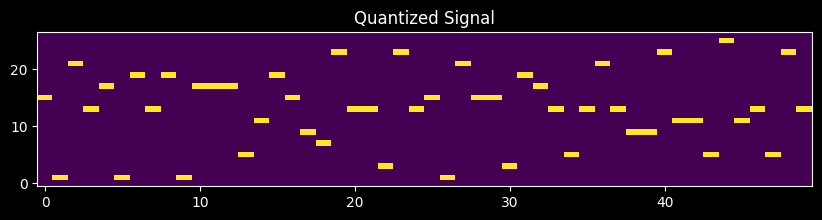

In [55]:
# convert the signal to a tensor
xqt = torch.tensor(xq/EPSI + nlevels//2, dtype=torch.int64)
# #convert to a vector of 1-hot encoded values
xq_1hot = F.one_hot(xqt, num_classes=nlevels)
# plot the 2dmatrix 
plt.figure(figsize=(10, 2))
plt.imshow(xq_1hot.T, aspect='auto', interpolation='none', origin='lower')
plt.title('Quantized Signal')
plt.show()

In [56]:
# calculate entropy
hloss = HLoss()
h = hloss(xq_1hot.to(torch.float32).unsqueeze(0))/N_SAMPLES
print(f'Entropy of the quantized signal: {h:.2f}')

Entropy of the quantized signal: 3.26


# ENTROPY IS NOT DIFFERENTIABLE
## But apparently these mutherfuckers found a way to do it
$$
 \frac{\partial{H}}{\partial{r_i}} = \lim_{b \to \infty} \sum_{j=0}^{|S|} [1 + \ln p(s_j)] * R(r_i - s_j)
$$

with $R$:

$$
R(r_i - s_j) = \frac{b}{|r|\varepsilon^b} \frac{(r_i - s_j)^{b-1}}{\left[\frac{(r_i -
s_j)^b}{\varepsilon^b} + 1\right]^2} $$

Master thesis version:

$$ 
R = \frac{b}{\left( \text{size}(rq) \cdot \varepsilon^b \right)} \cdot \frac{(rq - s_j)^{b-1}}{\left( \frac{(rq - s_j)^b}{\varepsilon^b} + 1 \right)^2}
$$

In [57]:
# see what this fucking function actually looks like
# def dentropy(r, b=10, ε=0.1):
#     symbols, counts = np.unique(r, return_counts=True)
#     p = counts/len(r)
#     log2p = np.log2(p)
#     H = -np.sum(p*log2p) # entropy
#     sizer = len(r)
#     print(f'sizer: {sizer}')

#     DH = np.zeros_like(r)
#     for i in range(len(r)):
#         dhi = 0
#         for j in range(len(symbols)):
#             a1 = (1 + log2p[j] + 1e-8)
#             print(f'1: {a1}')
#             a2 = b / (sizer * ε**b)
#             print(f'2: {a2}')
#             a3 = ( r[i] - symbols[j] )**(b-1) 
#             print(f'3: {a3}')
#             a4 = (((r[i]-symbols[j])/ε)**b + 1)**2
#             print(f'4: {a4}')
#             dhi += a1 * a2 * a3
#             print(f'comb: {a1*a2*a3/a4}\n')
#         DH[i] = dhi
#     return H, DH

def dentropy(rq, b=10.0, ε=0.1):
    # print(f'rq: {rq}')
    symbols, counts = np.unique(rq, return_counts=True)

    # sort the unique values
    order = np.argsort(symbols)
    symbols = symbols[order]
    counts = counts[order]

    p = counts/len(rq)
    # logp = np.log2(p + 1e-8)
    logp = np.log(p + 1e-8)
    H = -np.sum(p*logp) # entropy
    sizer = len(rq)

    DH = 0
    for j in range(len(symbols)):
        DH += (1+logp[j])*b / (sizer*ε**b) * (rq-symbols[j])**(b-1) / (((rq-symbols[j])/ε)**b+1)**2
    return H, DH

H, DH = dentropy(xq, b=10, ε=EPSI)

print(f'Entropy of the quantized signal: {H:.2f}')
print(f'Differential Entropy of the quantized signal: {DH}')
        





Entropy of the quantized signal: 2.42
Differential Entropy of the quantized signal: [ 4.504e-04  1.442e-03  5.067e-07 -1.452e-04  1.454e-04  1.442e-03
  3.320e-04 -1.452e-04  3.320e-04  1.442e-03  1.454e-04  1.454e-04
  1.454e-04  4.505e-04 -7.828e-04  3.320e-04  4.504e-04 -9.011e-04
  1.867e-04  7.134e-04 -1.452e-04 -1.452e-04  9.326e-07  7.134e-04
 -1.452e-04  4.504e-04  1.442e-03  5.067e-07  4.504e-04  4.504e-04
  9.326e-07  3.320e-04  1.454e-04 -1.452e-04  4.505e-04 -1.452e-04
  5.067e-07 -1.452e-04 -9.011e-04 -9.011e-04  7.134e-04 -7.828e-04
 -7.828e-04  4.505e-04 -9.920e-04 -7.828e-04 -1.452e-04  4.505e-04
  7.134e-04 -1.452e-04]


In [ ]:
# master thesis version in tensorflow
import tensorflow as tf
np.set_printoptions(precision=3)



def quantized_entropy_loss(epsilon,b=10.0):
  
  @tf.custom_gradient
  def loss_func(r):
    
    #Quantization
    rq = tf.cast((2*epsilon) * tf.math.round(r/(2*epsilon)), dtype=tf.float64) #epsilon is the quantization step


    # Calculate entropy
    unique_rq, _, count_rq = tf.unique_with_counts(tf.reshape(rq, [-1]))

    # sort the unique values
    unique_rq, count_rq = zip(*sorted(zip(unique_rq, count_rq)))
    order = np.argsort(unique_rq)
    unique_rq = np.array(unique_rq)[order]
    count_rq = np.array(count_rq)[order]

    # print(f'unique_rq: {unique_rq}')
    # print(f'count_rq: {count_rq}')

    p_rq = count_rq / tf.reduce_sum(count_rq) #probability of each unique residual
    QEL = tf.cast( -tf.reduce_sum(p_rq * tf.math.log(p_rq + 1e-8)), dtype=tf.float32)

    #Gradient approximation
    def R(rq, sj, b=b, epsilon=epsilon):
      return (b / (tf.cast(tf.size(rq), dtype=tf.float64) * epsilon**b)) * ((rq - sj)**(b-1)) / (((rq - sj)**b / epsilon**b) + 1)**2
    def grad(upstream):
      gradient_approx = 0.0 #dH/dr
      for sj,pj in zip(unique_rq, p_rq):
        # a1 = (1 + tf.math.log(pj + 1e-8))
        # print(f'a1: {a1}')
        gradient_approx += (1 + tf.math.log(pj + 1e-8)) * R(rq,sj)
      print(f'gradient_approx: {gradient_approx}')
      return upstream * tf.cast(gradient_approx, dtype=tf.float32)
    
    return QEL, grad

  return loss_func

# test the function on x
xtf = tf.constant(x, dtype=tf.float32)
# qel = quantized_entropy_loss(EPSI, b=10)(xtf)

# calculate the gradient
with tf.GradientTape() as tape:
    tape.watch(xtf)
    qel = quantized_entropy_loss(EPSI, b=10)(xtf)
dqel_dx = tape.gradient(qel, xtf)


print(f'Entropy of the quantized signal: {qel:.2f}')


gradient_approx: [ 4.504e-04  1.442e-03  5.089e-07 -1.452e-04  1.454e-04  1.442e-03
  3.320e-04 -1.452e-04  3.320e-04  1.442e-03  1.454e-04  1.454e-04
  1.454e-04  4.505e-04 -7.828e-04  3.320e-04  4.504e-04 -9.011e-04
  1.867e-04  7.134e-04 -1.452e-04 -1.452e-04  9.369e-07  7.134e-04
 -1.452e-04  4.504e-04  1.442e-03  5.089e-07  4.504e-04  4.504e-04
  9.369e-07  3.320e-04  1.454e-04 -1.452e-04  4.505e-04 -1.452e-04
  5.089e-07 -1.452e-04 -9.011e-04 -9.011e-04  7.134e-04 -7.828e-04
 -7.828e-04  4.505e-04 -9.920e-04 -7.828e-04 -1.452e-04  4.505e-04
  7.134e-04 -1.452e-04]
Entropy of the quantized signal: 2.42


## Let's see if there is correlation between the softmax differentiable function and the real entropy

100%|██████████| 2000/2000 [00:07<00:00, 284.84it/s]


best fit: y = 1.00x + 0.00


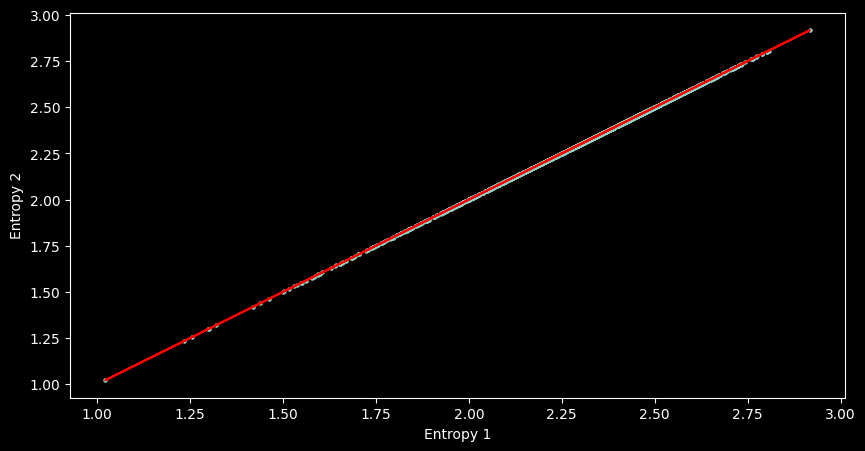

In [59]:
# test on a lot of tries
H1s, H2s = [], []
for _ in tqdm(range(2000)):
    # generate random frequencies
    fs = uni(0, N_SAMPLES/20, N_FREQS)
    As = uni(0, 1, N_FREQS)
    φs = uni(0, 2*π, N_FREQS)
    t = np.arange(N_SAMPLES)

    # generate the signal
    x = np.sum([As[i]*np.sin(2*π*fs[i]*t+φs[i]) for i in range(N_FREQS)], axis=0)

    # quantize the signal
    xq = quantize(x, EPSI)

    nlevels = int(1+2*np.ceil(np.max(np.abs(x))/EPSI))

    # measure entropy of the signal
    H1s.append(entropy(xq)) 

    # # H2
    # # convert the signal to a tensor
    # xqt = torch.tensor(xq/EPSI + nlevels//2, dtype=torch.int64)
    # #convert to a vector of 1-hot encoded values
    # xq_1hot = F.one_hot(xqt, num_classes=nlevels)
    # # calculate entropy 2 
    # h = hloss(xq_1hot.to(torch.float32).unsqueeze(0))/N_SAMPLES

    # tensorflow version
    xtf = tf.constant(x, dtype=tf.float32)
    h = quantized_entropy_loss(EPSI, b=10)(xtf)
    
    H2s.append(h)

H1s, H2s = np.array(H1s), np.array(H2s)

# get the best linear fit between H1s and H2s
A = np.vstack([H1s, np.ones(len(H1s))]).T
m, c = np.linalg.lstsq(A, H2s, rcond=None)[0]
print(f'best fit: y = {m:.2f}x + {c:.2f}')

plt.figure(figsize=(10, 5))
plt.scatter(H1s, H2s, s=5)
plt.plot(H1s, m*H1s + c, color='red')
plt.xlabel('Entropy 1')
plt.ylabel('Entropy 2')
plt.show()


In [60]:
# criterion = HLoss()
# x = Variable(torch.randn(10, 10))
# w = Variable(torch.randn(10, 3), requires_grad=True)
# output = torch.matmul(x, w)
# loss = criterion(output)
# loss.backward()
# print(w.grad)